In [1]:
from collections import Counter
from itertools import product
import os
import sys

import dill
import evaluate
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pacmap import PaCMAP
import pandas as pd
import seaborn as sns
import sklearn.cluster as cluster
import sklearn.metrics.pairwise as pairwise
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [2]:
with open("./data/trivia_qa/lmsys_vicuna-7b-v1.5/calibration_data/in_context_10/cluster_data.dill", "rb") as cluster_data_file:
    cluster_data = dill.load(cluster_data_file)

print(cluster_data.keys())

dict_keys(['accuracies', 'embeddings', 'questions', 'transformed_embeddings', 'cluster_assignments', 'calibration_targets'])


In [3]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=cluster_data["accuracies"], y_score=[cluster_data["calibration_targets"][cluster] for cluster in cluster_data["cluster_assignments"]])


0.6997990634218402

In [4]:
print(cluster_data.keys())
print(cluster_data)

dict_keys(['accuracies', 'embeddings', 'questions', 'transformed_embeddings', 'cluster_assignments', 'calibration_targets'])
{'accuracies': array([1, 1, 0, ..., 0, 0, 0]), 'embeddings': array([[-0.11414, -0.609  , -0.839  , ...,  0.1146 , -1.513  , -0.367  ],
       [-0.593  ,  1.357  ,  0.2852 , ...,  0.753  , -0.4448 ,  0.336  ],
       [-0.4316 , -0.2502 , -0.3008 , ..., -1.275  , -0.8335 , -0.0527 ],
       ...,
       [ 0.2393 ,  0.0941 ,  0.1122 , ..., -0.5566 ,  1.2295 ,  1.382  ],
       [ 1.137  , -0.329  , -0.2815 , ..., -0.41   , -0.2172 , -0.4006 ],
       [ 0.6104 ,  1.881  , -0.12054, ...,  1.106  ,  0.937  ,  0.8667 ]],
      dtype=float16), 'questions': array(['Which American-born Sinclair won the Nobel Prize for Literature in 1930?',
       'Where in England was Dame Judi Dench born?',
       'In which decade did Billboard magazine first publish and American hit chart?',
       ...,
       "Who was the most recent U.S. president who was not selected as Time's Person of

In [5]:
num_print_clusters = 10
print_clusters = np.random.choice(np.unique(cluster_data["cluster_assignments"]), size=num_print_clusters, replace=False)
print(print_clusters)
questions = np.array(cluster_data["questions"])
import time
cluster_indices = cluster_data["cluster_assignments"]

for cluster in print_clusters:
    cluster_questions = questions[cluster_indices == cluster]

    print(f"### Cluster {cluster + 1} ###")
    for question in cluster_questions:
        print(question)
        time.sleep(0.1)

    print("")

[ 154  188  243  302 1251 1378  394  476 1110  755]
### Cluster 155 ###
What is the name of the membership only warehouse club owned and operated by Wal-Mart that ranks second to Costco in sales volume?
In terms of sales, Lowe's is the world's second-largest hardware store chain, behind which retailer?
With 6 local locations, what is the name of the clearance store operated by local upscale retailer Nordstroms?

### Cluster 189 ###
How many American men are gay?
How many men in the UK are openly homosexual?
What proportion of Canadians are straight?

### Cluster 244 ###
James Todd Smith, born 1968, is an American award winning rapper and actor. What is he better known as?
Which songwriter and rapper’s real name is Timothy Z Mosley?
Which rapper’s real name is Louise Harman?
Which rapper’s real name is Shawn Carter?

### Cluster 303 ###
What type of cancer kills the most women in the U.S.?
How has the rate of smoking changed over time among Americans?
How has the rate of lung cancer dea

In [6]:
def plot_clusters(transformed_embeddings, cluster_assignments, subsample_percentage = 0.5):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.grid(alpha=0.8, visible=True)

    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

    cmap = matplotlib.cm.get_cmap('Spectral')
    labels = np.unique(cluster_assignments)
    labels = np.setdiff1d(labels, [-1])
    np.random.shuffle(labels)
    import math
    
    for i, label in enumerate(labels):
        if i > math.ceil(len(labels) * subsample_percentage):
            break
        
        plt.scatter(
            transformed_embeddings[cluster_assignments == label][:, 0], 
            transformed_embeddings[cluster_assignments == label][:, 1],
            color = cmap(np.random.uniform(size=1)),
            alpha=0.6,
            s=60,
            marker=np.random.choice(["o", "*", "^", "v", "<", ">", "s", "p", "P", "h", "X", "D"], size=1)[0]
        )

    plt.scatter(
        transformed_embeddings[cluster_assignments == label][:, 0], 
        transformed_embeddings[cluster_assignments == label][:, 1],
        color = "gray",
        alpha= 0.1,
        s=30,
        marker="o"
    )

    plt.tight_layout()
    plt.show()

In [7]:
def plot_clusters_by_confidence(transformed_embeddings, cluster_assignments, cluster2confidence, subsample_percentage = 0.4, num_ood = None):
    plt.figure(figsize=(7.6,7))
    ax = plt.gca()
    ax.grid(alpha=0.8, visible=True)

    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

    cmap = matplotlib.cm.get_cmap('coolwarm')
    labels = np.unique(cluster_assignments)
    labels = np.setdiff1d(labels, [-1])
    np.random.shuffle(labels)
    import math

    # Indices
    indices = np.arange(0, transformed_embeddings.shape[0])
    cutoff = transformed_embeddings.shape[0] - num_ood
    
    for i, label in enumerate(labels):
        if i > math.ceil(len(labels) * subsample_percentage):
            break

        cluster_indices = indices[cluster_assignments == label]
        
        for x, y, marker, marker_size in zip(
            transformed_embeddings[cluster_assignments == label][:, 0],
            transformed_embeddings[cluster_assignments == label][:, 1],
            ["o" if idx < cutoff else "*" for idx in cluster_indices],
            [130 if idx < cutoff else 150 for idx in cluster_indices]
        ):
            plt.scatter(
                x, 
                y,
                color = cmap(cluster2confidence[label]),
                alpha=0.2,
                s=marker_size,
                marker=marker
            )

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("./clusters.png")

/var/folders/x5/v784_txx61d1f2cd3n6g5r040000gn/T/ipykernel_48371/534410207.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


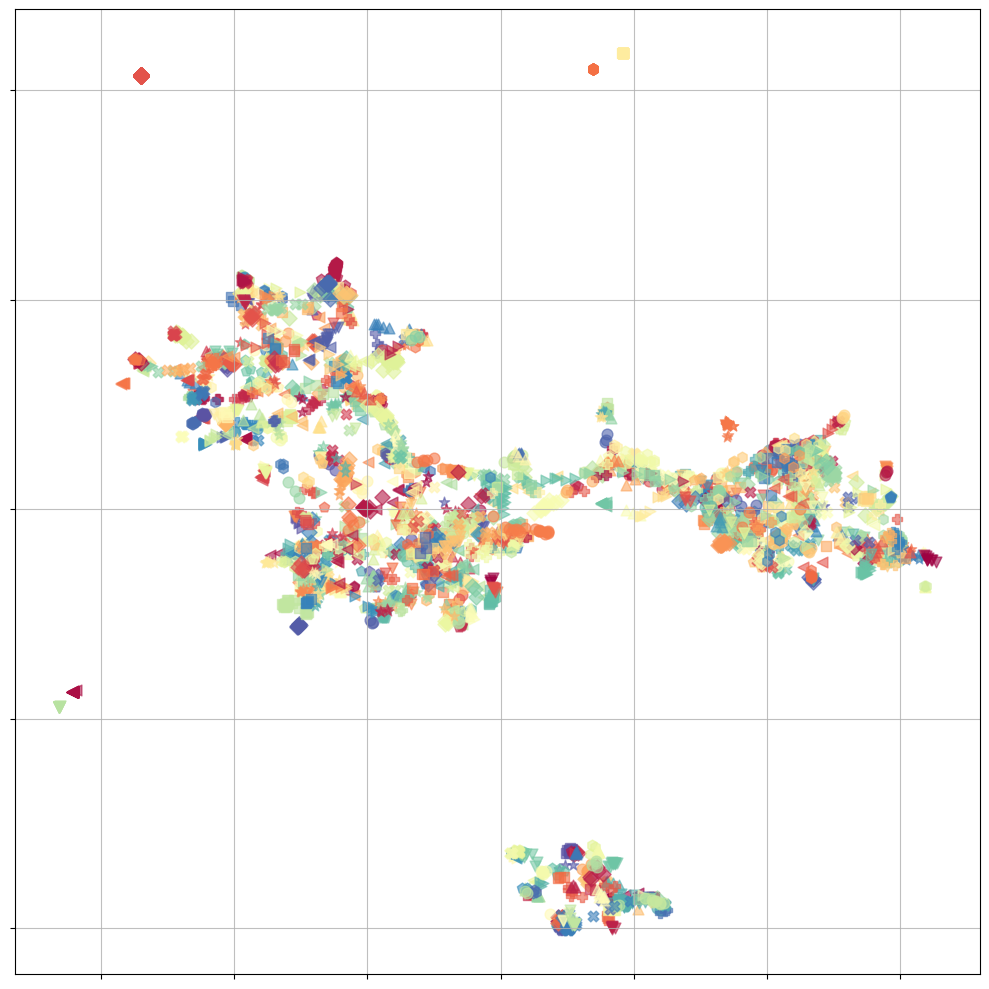

In [8]:
plot_clusters(cluster_data["transformed_embeddings"], cluster_data["cluster_assignments"])
# TODO: Rank cluster by confidence and look at questiond

/var/folders/x5/v784_txx61d1f2cd3n6g5r040000gn/T/ipykernel_48371/1158288784.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')


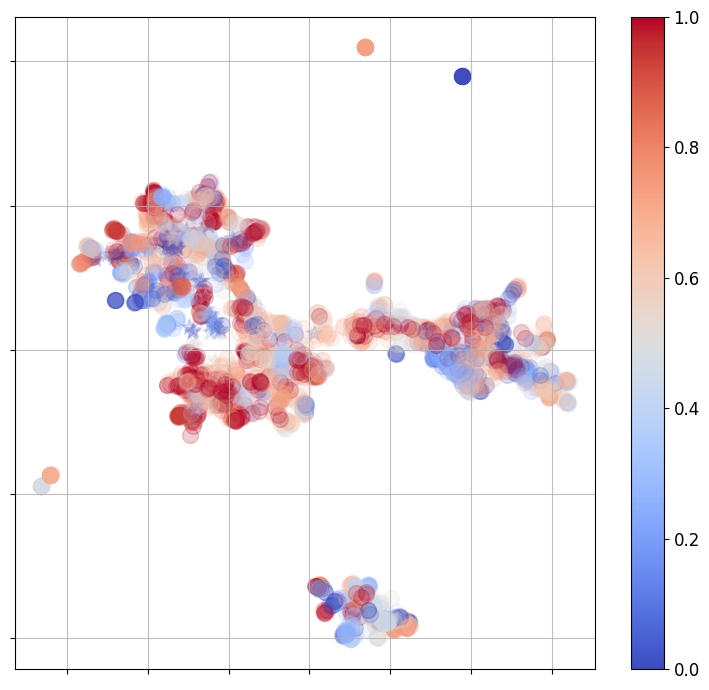

In [9]:
plot_clusters_by_confidence(
    cluster_data["transformed_embeddings"], 
    cluster_data["cluster_assignments"], 
    cluster_data["calibration_targets"], 
    num_ood=817
)

In [10]:
cluster_data.keys()

dict_keys(['accuracies', 'embeddings', 'questions', 'transformed_embeddings', 'cluster_assignments', 'calibration_targets'])

In [11]:
def plot_cluster_sizes(cluster_assignments, num_bins: int = 27):
    cluster_sizes = [np.sum((cluster_assignments == label).astype(int)) for label in np.unique(cluster_assignments) if label != -1] 
    print(cluster_sizes)

    ax = plt.gca()
    plt.hist(cluster_sizes, bins=max(cluster_sizes) - 3, alpha=0.7, width=0.9)
    ax.grid(visible=False, axis="x")
    labels = range(min(cluster_sizes), max(cluster_sizes), 15)
    plt.xticks(
        ticks=range(min(cluster_sizes), max(cluster_sizes), 1), 
        labels=range(min(cluster_sizes), max(cluster_sizes), 1)
    )

    plt.xlabel("Cluster size", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim([0, 20])
    
    plt.tight_layout()
    #plt.show()
    plt.savefig("./cluster_sizes.png")
    
    

In [12]:
def plot_calibration_targets(calibration_targets):
    targets = list(calibration_targets.values())

    sns.set_style('whitegrid')
    sns.kdeplot(np.array(targets), clip=[0, 1], common_norm=True, common_grid=True)
    plt.xlabel("Calibration target", fontsize=14)
    plt.ylabel("Density", fontsize=14)

    #freqs = Counter(targets)

    #for k, v in freqs.items():
    #    for i in range(v):
    #        plt.scatter(k, i * 0.04, alpha=0.3, marker="_", color="black", s=20)

    plt.xlim([0, 1])

    #plt.show()
    plt.tight_layout()
    plt.savefig("./calibration_targets.png")

In [13]:
def compute_cluster_textual_similarity(cluster_assignments, questions, max_comparisons: int = 5, max_total_comparisons: int = 200):
    questions = np.array(questions)
    all_cluster_scores = []

    rouge = evaluate.load('rouge')
    pbar = tqdm(total=max_total_comparisons)

    total_comparisons = 0
    labels = np.unique(cluster_assignments)
    np.random.shuffle(labels)
    for label in labels:
        if label == -1:
            continue

        if total_comparisons > max_total_comparisons:
            break

        cluster_questions = questions[label == cluster_assignments]
        comparisons = 0
        cluster_scores = []

        for a, b in product(cluster_questions, repeat=2):
            if a == b:
                continue

            if comparisons > max_comparisons:
                break
            
            comparisons += 1
            total_comparisons +=1
            pbar.update(1)
            results = rouge.compute(predictions=[a], references=[b])
            cluster_scores.append(results["rougeL"])

        if len(cluster_scores) > 0:
            all_cluster_scores.append(np.mean(cluster_scores))

    # Compute baselines scores
    all_baseline_scores = []

    for _ in tqdm(range(total_comparisons)):
        a, b = np.random.choice(questions, size=2, replace=False)
        results = rouge.compute(predictions=[a], references=[b])
        all_baseline_scores.append(results["rougeL"])

    return all_cluster_scores, all_baseline_scores

In [14]:
def compute_cluster_semantic_similarity(cluster_assignments, embeddings, max_comparisons: int = 5, max_total_comparisons: int = 200):
    all_cluster_scores = []
    total_comparisons = 0
    pbar = tqdm(total=max_total_comparisons)

    labels = np.unique(cluster_assignments)
    np.random.shuffle(labels)
    for label in labels:
        if label == -1:
            continue

        if total_comparisons > max_total_comparisons:
            break

        cluster_embeddings = embeddings[label == cluster_assignments]
        comparisons = 0
        cluster_scores = []

        for a, b in product(cluster_embeddings, repeat=2):
            if np.all(a == b):
                continue

            if comparisons > max_comparisons:
                break
            
            comparisons += 1
            pbar.update(1)
            total_comparisons += 1
            result = pairwise.cosine_similarity(a[np.newaxis, ...], b[np.newaxis, ...])
            cluster_scores.append(result)

        if len(cluster_scores) > 0:
            all_cluster_scores.append(np.mean(cluster_scores))

    # Compute baselines scores
    all_baseline_scores = []

    import random
    embeddings = list(np.split(embeddings, embeddings.shape[0], axis=0))
    for _ in tqdm(range(total_comparisons)):
        a = random.choice(embeddings)
        b = random.choice(embeddings)
        result = pairwise.cosine_similarity(a, b)
        all_baseline_scores.append(result)

    return all_cluster_scores, all_baseline_scores
    

[3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 6, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 5, 3, 4, 3, 3, 3, 3, 3, 4, 8, 3, 4, 5, 4, 3, 3, 3, 4, 3, 3, 5, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 7, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 5, 3, 3, 3, 3, 4, 6, 3, 4, 4, 3, 3, 3, 7, 3, 4, 6, 3, 3, 5, 9, 4, 3, 3, 3, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 4, 3, 4, 4, 4, 3, 3, 6, 3, 3, 4, 5, 6, 3, 3, 3, 4, 3, 3, 3, 3, 9, 7, 3, 4, 3, 4, 5, 3, 6, 4, 3, 3, 7, 3, 5, 3, 3, 5, 9, 3, 4, 3, 3, 3, 3, 3, 5, 4, 4, 8, 4, 3, 3, 6, 3, 5, 3, 4, 3, 3, 3, 5, 3, 4, 10, 4, 5, 5, 3, 4, 3, 7, 9, 3, 5, 3, 7, 3, 9, 3, 5, 3, 3, 4, 7, 5, 4, 5, 3, 5, 3, 4, 3, 4, 4, 3, 5, 3, 3, 5, 3, 3, 3, 9, 3, 4, 4, 4, 3, 5, 3, 3, 4, 3, 3, 4, 4, 5, 3, 5, 5, 4, 4, 6, 6, 5, 3, 3, 8, 3, 5, 3, 3, 3, 4, 3, 3, 8, 26, 3, 5, 3, 5, 3, 4, 3, 3, 3, 7, 9, 3, 3, 3, 8, 3, 3, 5, 5, 4, 3, 3, 14, 9, 3, 10, 18, 9, 3, 3, 8, 4, 4, 5, 5, 7, 9, 3, 16, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 6, 3, 8, 3, 7, 8, 11, 3, 3, 5, 3, 3, 3, 3, 4, 3, 3, 4, 6, 3, 3, 3, 3, 12, 3

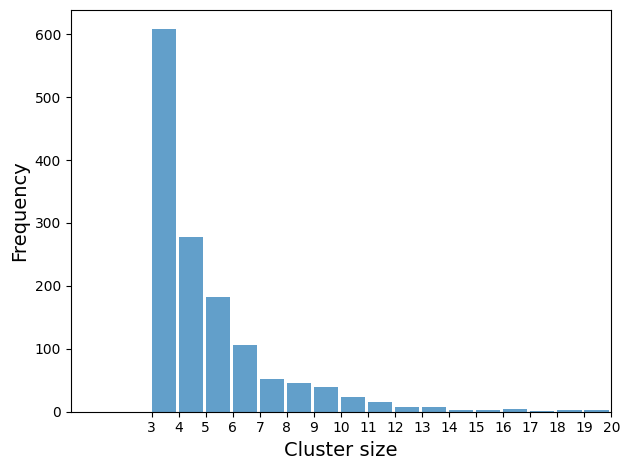

In [15]:
plot_cluster_sizes(cluster_data["cluster_assignments"])

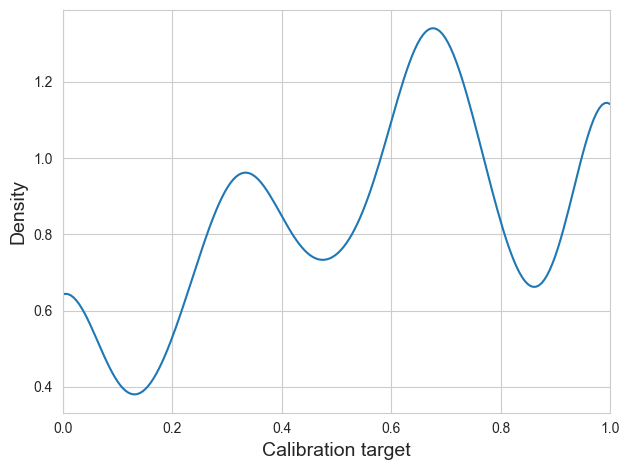

In [16]:
plot_calibration_targets(cluster_data["calibration_targets"])

In [17]:
cluster_similarities, baselines_similarities = compute_cluster_textual_similarity(cluster_data["cluster_assignments"], cluster_data["questions"])
print(f"Mean similarity {np.mean(cluster_similarities):.2f}±{np.std(cluster_similarities):.2f}")
print(f"Random mean similarity {np.mean(baselines_similarities):.2f}±{np.std(baselines_similarities):.2f}")

203it [00:08, 23.70it/s]                                                                                                                                                 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:08<00:00, 23.41it/s]
204it [00:17, 11.79it/s]

Mean similarity 0.36±0.22
Random mean similarity 0.11±0.09


In [18]:
cluster_cosines, baselines_cosines = compute_cluster_semantic_similarity(cluster_data["cluster_assignments"], cluster_data["embeddings"])
print(f"Mean similarity {np.mean(cluster_cosines):.2f}±{np.std(cluster_cosines):.2f}")
print(f"Random mean similarity {np.mean(baselines_cosines):.2f}±{np.std(baselines_cosines):.2f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 7357.67it/s]
204it [00:00, 2926.25it/s]                                                                                                                                               

Mean similarity 0.60±0.11
Random mean similarity 0.00±0.10


### GPT-3.5 results

In [19]:
cm_cluster_data = dict(cluster_data)

with open(f"./data/trivia_qa/gpt-3.5-turbo-0125/calibration_data/in_context_10/calibration_targets.dill", "rb") as cluster_data_file:
    split_data = dill.load(cluster_data_file)

    for i, key in enumerate(split_data.keys()):
        cm_cluster_data["calibration_targets"][i] = split_data[key]

/var/folders/x5/v784_txx61d1f2cd3n6g5r040000gn/T/ipykernel_48371/534410207.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


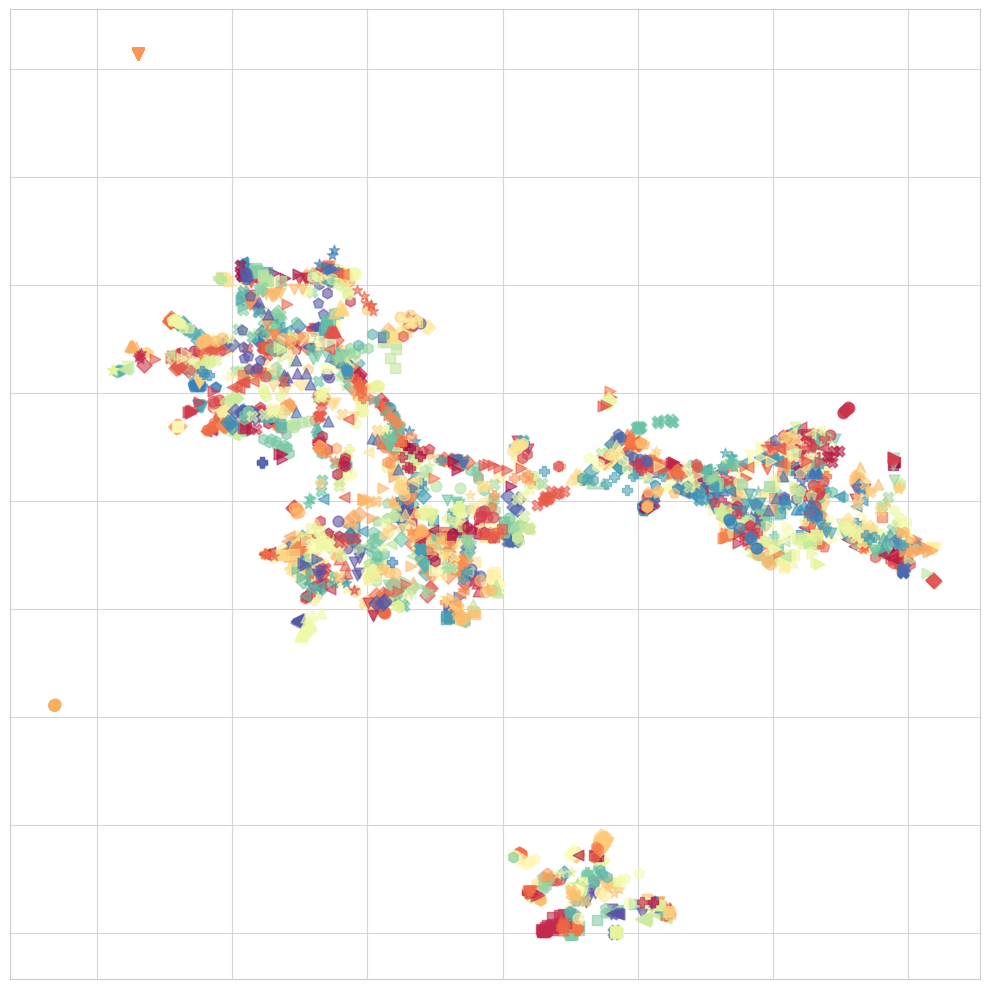

In [20]:
plot_clusters(cm_cluster_data["transformed_embeddings"], cm_cluster_data["cluster_assignments"])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 6, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 5, 3, 4, 3, 3, 3, 3, 3, 4, 8, 3, 4, 5, 4, 3, 3, 3, 4, 3, 3, 5, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 7, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 5, 3, 3, 3, 3, 4, 6, 3, 4, 4, 3, 3, 3, 7, 3, 4, 6, 3, 3, 5, 9, 4, 3, 3, 3, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 4, 3, 4, 4, 4, 3, 3, 6, 3, 3, 4, 5, 6, 3, 3, 3, 4, 3, 3, 3, 3, 9, 7, 3, 4, 3, 4, 5, 3, 6, 4, 3, 3, 7, 3, 5, 3, 3, 5, 9, 3, 4, 3, 3, 3, 3, 3, 5, 4, 4, 8, 4, 3, 3, 6, 3, 5, 3, 4, 3, 3, 3, 5, 3, 4, 10, 4, 5, 5, 3, 4, 3, 7, 9, 3, 5, 3, 7, 3, 9, 3, 5, 3, 3, 4, 7, 5, 4, 5, 3, 5, 3, 4, 3, 4, 4, 3, 5, 3, 3, 5, 3, 3, 3, 9, 3, 4, 4, 4, 3, 5, 3, 3, 4, 3, 3, 4, 4, 5, 3, 5, 5, 4, 4, 6, 6, 5, 3, 3, 8, 3, 5, 3, 3, 3, 4, 3, 3, 8, 26, 3, 5, 3, 5, 3, 4, 3, 3, 3, 7, 9, 3, 3, 3, 8, 3, 3, 5, 5, 4, 3, 3, 14, 9, 3, 10, 18, 9, 3, 3, 8, 4, 4, 5, 5, 7, 9, 3, 16, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 6, 3, 8, 3, 7, 8, 11, 3, 3, 5, 3, 3, 3, 3, 4, 3, 3, 4, 6, 3, 3, 3, 3, 12, 3

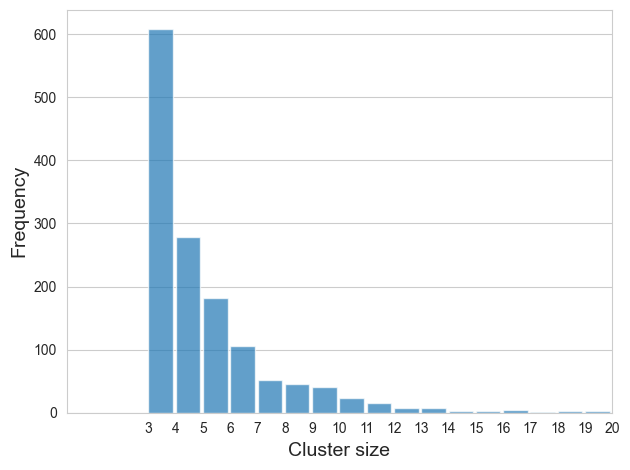

In [21]:
plot_cluster_sizes(cm_cluster_data["cluster_assignments"])

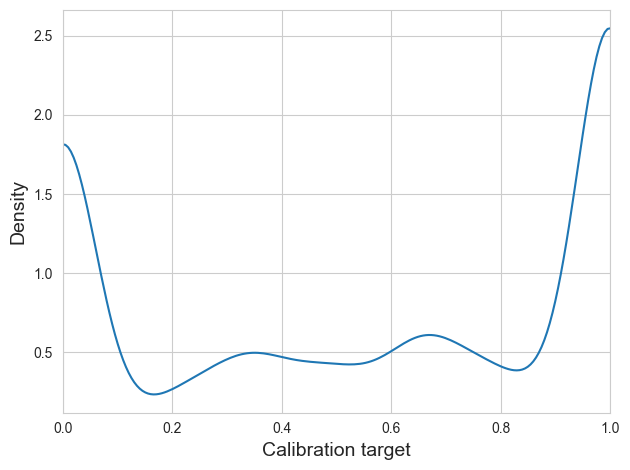

In [22]:
plot_calibration_targets(cm_cluster_data["calibration_targets"])

/var/folders/x5/v784_txx61d1f2cd3n6g5r040000gn/T/ipykernel_48371/1158288784.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')


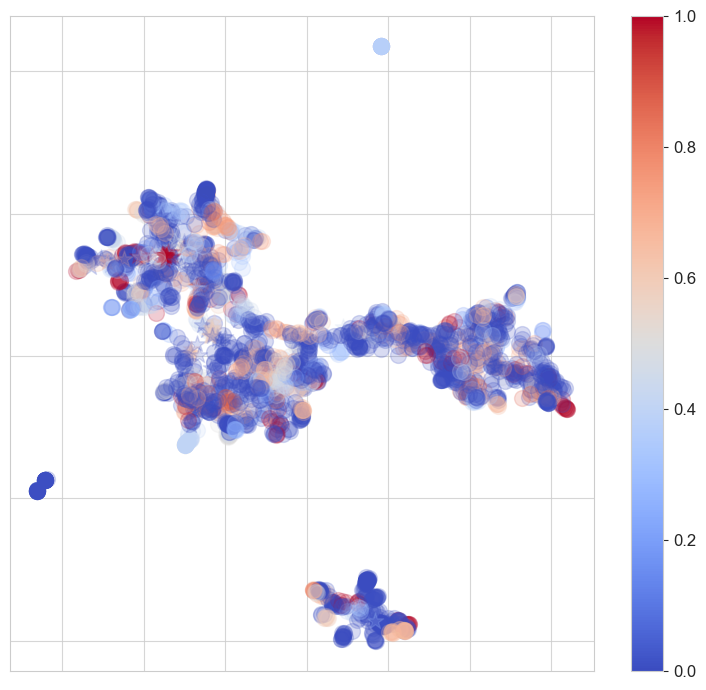

In [23]:
plot_clusters_by_confidence(
    cm_cluster_data["transformed_embeddings"], 
    cm_cluster_data["cluster_assignments"], 
    cm_cluster_data["calibration_targets"],
    num_ood=817
)

# CoQA Rresults

In [27]:
with open("./data/coqa/lmsys_vicuna-7b-v1.5/calibration_data/in_context_0/cluster_data.dill", "rb") as cluster_data_file:
    cq_cluster_data = dill.load(cluster_data_file)

In [28]:
roc_auc_score(y_true=cq_cluster_data["accuracies"], y_score=[cq_cluster_data["calibration_targets"][cluster] for cluster in cq_cluster_data["cluster_assignments"]])


0.6931587038882017

In [37]:
cq_print_clusters = np.random.choice(np.unique(cq_cluster_data["cluster_assignments"]), size=20, replace=False)
print(cq_print_clusters)
cq_questions = np.array(cq_cluster_data["questions"])
import time
cq_cluster_indices = cq_cluster_data["cluster_assignments"]

for cluster in cq_print_clusters:
    cq_cluster_questions = cq_questions[cq_cluster_indices == cluster]

    print(f"### Cluster {cluster + 1} ###")
    for question in cq_cluster_questions:
        print(question)
        time.sleep(0.1)

    print("")

[ 822  873 1175  243   10 1097 1080 1137  497 1043  578 1035  412 1153
  712  464  672  810  840  985]
### Cluster 823 ###
Where in Europe is it located?
Is it in the European Plain?
Which region of Europe is it in?

### Cluster 874 ###
did she like it the most?
Did she like it immediately?
Did she like it?

### Cluster 1176 ###
Did she have children?
Does she have any children?
Did she have any children?
Did she have any other children?

### Cluster 244 ###
Who won the Kentucky Derby?
Has he won the Derby before?
Has he raced in the Derby before?
What were the winning horse's odds?
How many Derbys have their been?

### Cluster 11 ###
Are they densities of everything the same?
What is the densest elements at regular conditions?
What is density of a substance?
What is another symbol for density?
Who gives weight per unit volume as the definition?
Where is density the same value as it's mass concentration?
To make comparisons easier what stands in for density?
What is the relative densit

[16, 8, 9, 9, 3, 3, 3, 6, 3, 5, 8, 3, 3, 3, 12, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 4, 20, 3, 38, 9, 57, 25, 11, 13, 10, 5, 5, 5, 3, 3, 3, 3, 5, 7, 5, 3, 4, 3, 6, 5, 3, 7, 3, 3, 4, 3, 3, 5, 3, 4, 14, 4, 3, 4, 5, 4, 4, 3, 3, 11, 9, 4, 21, 7, 4, 3, 3, 3, 3, 5, 7, 5, 4, 5, 3, 5, 4, 8, 5, 5, 6, 5, 3, 5, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 6, 6, 5, 5, 5, 3, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 7, 8, 5, 5, 3, 4, 4, 8, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 10, 5, 3, 3, 3, 3, 3, 4, 3, 6, 7, 3, 3, 4, 4, 7, 3, 11, 3, 4, 4, 4, 3, 7, 3, 4, 5, 3, 4, 3, 4, 4, 3, 5, 3, 4, 4, 3, 3, 7, 3, 3, 3, 4, 3, 3, 3, 5, 3, 3, 5, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5, 7, 6, 4, 6, 3, 7, 5, 3, 3, 4, 4, 3, 4, 6, 3, 7, 3, 4, 3, 4, 7, 4, 11, 3, 14, 3, 5, 5, 5, 4, 3, 3, 3, 7, 5, 3, 4, 3, 3, 3, 3, 3, 3, 3, 9, 3, 10, 3, 3, 4, 7, 5, 3, 3, 3, 3, 3, 5, 4, 5, 3, 4, 4, 5, 5, 3, 3, 3, 4, 3, 3, 3, 4, 4, 5, 6, 6, 4, 3, 5, 5, 4, 8, 13, 3, 3, 4, 3, 3, 3, 7, 4, 5, 3, 4, 3, 3, 9, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 6, 3, 5, 6, 3, 3, 11, 5, 3, 5,

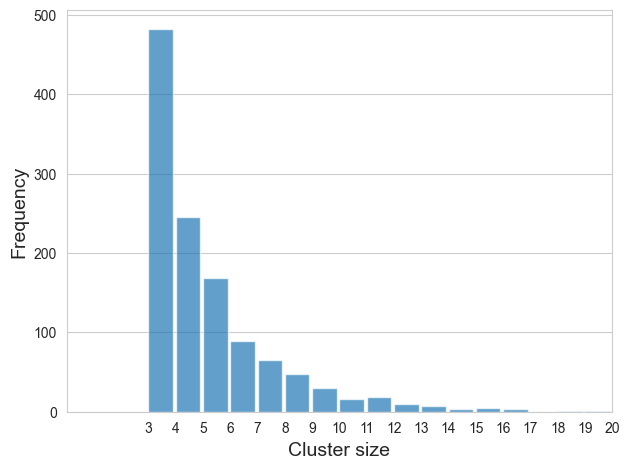

In [30]:
plot_cluster_sizes(cq_cluster_data["cluster_assignments"])

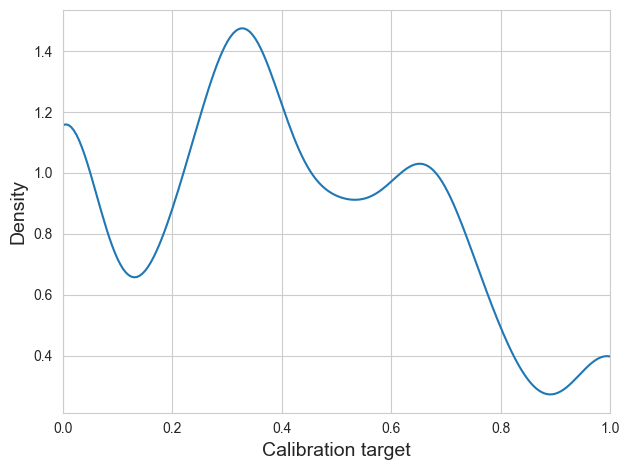

In [31]:
plot_calibration_targets(cq_cluster_data["calibration_targets"])

/var/folders/x5/v784_txx61d1f2cd3n6g5r040000gn/T/ipykernel_48371/1158288784.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')


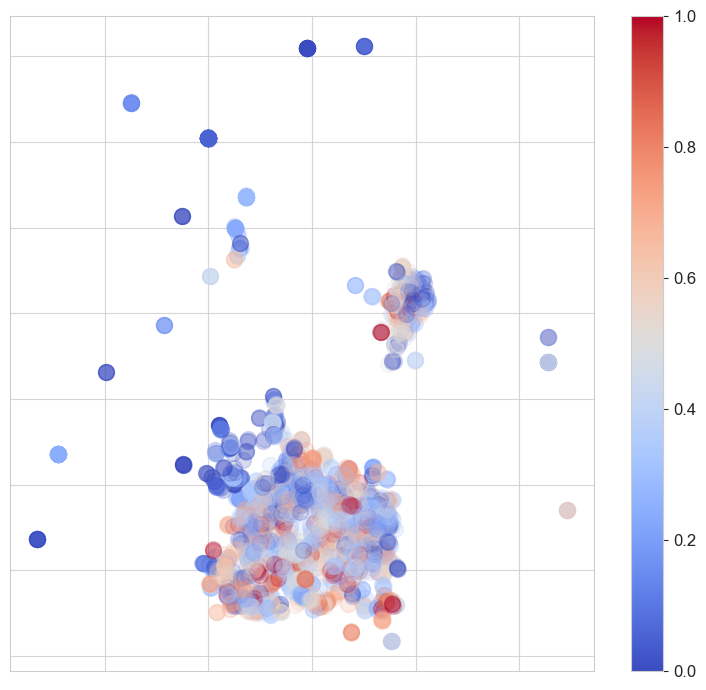

In [34]:
plot_clusters_by_confidence(
    cq_cluster_data["transformed_embeddings"], 
    cq_cluster_data["cluster_assignments"], 
    cq_cluster_data["calibration_targets"],
    num_ood=0
)

In [38]:
with open("./data/coqa/gpt-3.5-turbo-0125/calibration_data/in_context_0/cluster_data.dill", "rb") as cluster_data_file:
    cq_gpt_cluster_data = dill.load(cluster_data_file)

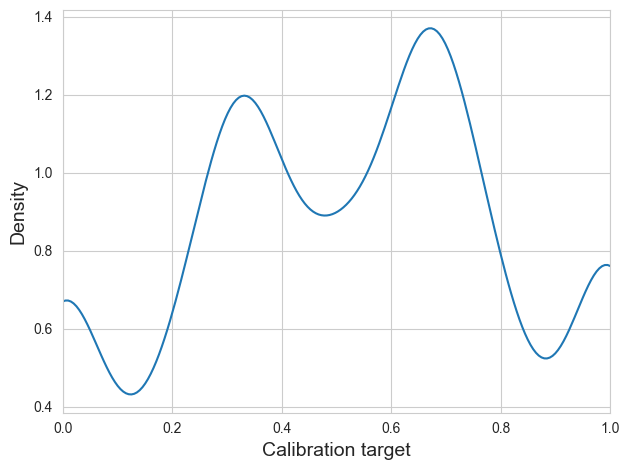

In [39]:
plot_calibration_targets(cq_gpt_cluster_data["calibration_targets"])

/var/folders/x5/v784_txx61d1f2cd3n6g5r040000gn/T/ipykernel_48371/1158288784.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')


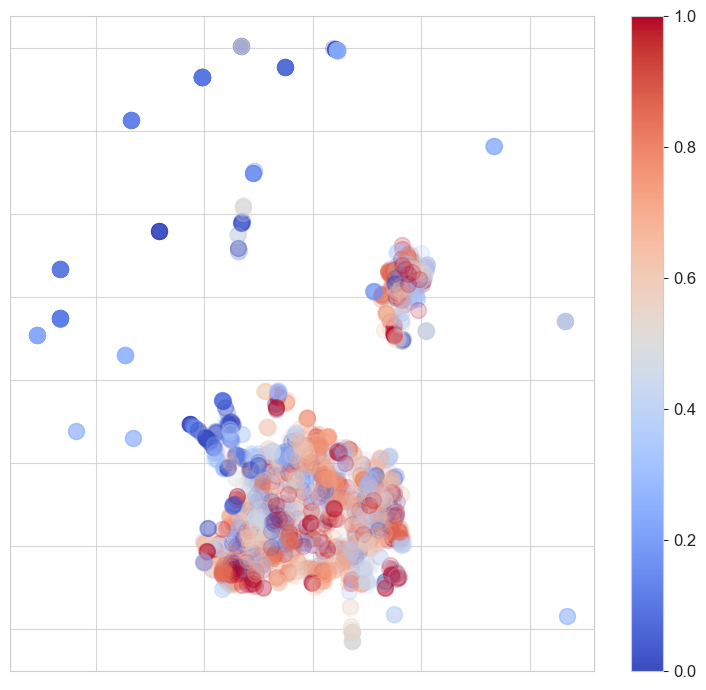

In [41]:
plot_clusters_by_confidence(
    cq_gpt_cluster_data["transformed_embeddings"], 
    cq_gpt_cluster_data["cluster_assignments"], 
    cq_gpt_cluster_data["calibration_targets"],
    num_ood=0
)

In [35]:
cq_cluster_similarities, cq_baselines_similarities = compute_cluster_textual_similarity(cq_cluster_data["cluster_assignments"], cq_cluster_data["questions"])
print(f"Mean similarity {np.mean(cq_cluster_similarities):.2f}±{np.std(cq_cluster_similarities):.2f}")
print(f"Random mean similarity {np.mean(cq_baselines_similarities):.2f}±{np.std(cq_baselines_similarities):.2f}")

204it [00:08, 23.40it/s]                                                                                                                                                 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:08<00:00, 23.22it/s]
204it [00:17, 11.67it/s]

Mean similarity 0.47±0.25
Random mean similarity 0.08±0.12


In [36]:
cq_cluster_cosines, cq_baselines_cosines = compute_cluster_semantic_similarity(cq_cluster_data["cluster_assignments"], cq_cluster_data["embeddings"])
print(f"Mean similarity {np.mean(cq_cluster_cosines):.2f}±{np.std(cq_cluster_cosines):.2f}")
print(f"Random mean similarity {np.mean(cq_baselines_cosines):.2f}±{np.std(cq_baselines_cosines):.2f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 7197.83it/s]
202it [00:00, 2102.38it/s]                                                                                                                                               

Mean similarity 0.70±0.17
Random mean similarity -0.00±0.12
